In [3]:
## read in data and pickle - don't need to run

import pandas as pd
import pickle as pkl

opt = pd.read_csv('option_data.csv')
fut = pd.read_csv('future_data.csv')

# pkl.dump(opt, open('option_data.pkl', 'wb'), protocol=pkl.HIGHEST_PROTOCOL)
# pkl.dump(fut, open('future_data.pkl', 'wb'), protocol=pkl.HIGHEST_PROTOCOL)

option_data = pkl.load(open('option_data.pkl', 'rb'))
future_data = pkl.load(open('future_data.pkl', 'rb'))

option_data.head()
future_data.head()

,DATE,SPX,VIX,SKEW
0,01/02/90,359.69,17.24,126.09
1,01/03/90,358.76,18.19,123.34
2,01/04/90,355.66,19.22,122.62
3,01/05/90,352.20,20.11,121.27
4,01/08/90,353.79,20.26,124.12


In [89]:
## cleaning option dataframe - don't need to run

df = option_data

df['expiration'] = pd.to_datetime(df['expiration'])
df['quotedate'] = pd.to_datetime(df['quotedate'])
df = df.drop(columns = ['underlying', ' exchange', 'optionroot', 'optionext', 'last', 'volume', 'openinterest', 'optionalias'])
df = df.rename(columns = {'underlying_last':'Underlying', 'type':'Type', 'expiration':'Expiration', 'quotedate':'Date', 'strike':'Strike', 'bid':'Bid', 'ask':'Ask', 'impliedvol':'Implied Vol', 'delta':'Delta', 'gamma':'Gamma', 'theta':'Theta', 'vega':'Vega'})
df = df.set_index('Date')
cols = ['Expiration', 'Strike', 'Type', 'Bid', 'Ask', 'Underlying', 'Implied Vol', 'Delta', 'Gamma', 'Theta', 'Vega']
df = df[cols]

option_data = df

# pkl.dump(option_data, open('clean_option_data.pkl', 'wb'), protocol=pkl.HIGHEST_PROTOCOL)

In [77]:
## cleaning future dataframe - don't need to run

df = future_data

df['DATE'] = pd.to_datetime(df['DATE'])
df = df.rename(columns = {'DATE':'Date'})
df = df.set_index('Date')

future_data = df

# pkl.dump(future_data, open('clean_future_data.pkl', 'wb'), protocol=pkl.HIGHEST_PROTOCOL)

,SPX,VIX,SKEW
Date,,,
1990-01-02,359.69,17.24,126.09
1990-01-03,358.76,18.19,123.34
1990-01-04,355.66,19.22,122.62
1990-01-05,352.20,20.11,121.27
1990-01-08,353.79,20.26,124.12


In [1]:
## ** START HERE ** ##

## merge and clean option and future data

import pandas as pd
import pickle as pkl
import datetime as dt
from datetime import datetime
import numpy as np
import bisect

clean_option_data = pkl.load(open('clean_option_data.pkl', 'rb'))
clean_future_data = pkl.load(open('clean_future_data.pkl', 'rb'))

# clean_option_data.head()
# clean_future_data.head()

clean_data = pd.merge(clean_option_data, clean_future_data, how = 'inner', left_index = True, right_index = True)

## difference in option data underlying & future data = 0.07%
# df['future_dif'] = abs(df['Underlying'] - df['SPX'])
# df['future_dif_perc'] = df['future_dif'] / df['SPX']
# df['future_dif_perc'].mean()*100

clean_data['Theo'] = clean_data[['Bid', 'Ask']].mean(axis = 1)
clean_data = clean_data.drop(columns = ['Underlying', 'Bid', 'Ask'])
cols = ['Expiration', 'Strike', 'Type', 'Theo', 'Implied Vol', 'Delta', 'Gamma', 'Theta', 'Vega', 'SPX', 'VIX', 'SKEW']
clean_data = clean_data[cols]
clean_data.head()

,Expiration,Strike,Type,Theo,Implied Vol,Delta,Gamma,Theta,Vega,SPX,VIX,SKEW
Date,,,,,,,,,,,,
2015-10-01,2015-10-16,400,call,1521.95,0.2589,1.0,0.0,-1.2854,0.0,1923.82,22.55,124.81
2015-10-01,2015-10-16,500,call,1422.00,0.2589,1.0,0.0,-1.6068,0.0,1923.82,22.55,124.81
2015-10-01,2015-10-16,600,call,1322.00,0.2589,1.0,0.0,-1.9282,0.0,1923.82,22.55,124.81
2015-10-01,2015-10-16,700,call,1222.05,0.2589,1.0,0.0,-2.2495,0.0,1923.82,22.55,124.81
2015-10-01,2015-10-16,750,call,1172.05,0.2589,1.0,0.0,-2.4102,0.0,1923.82,22.55,124.81


In [17]:
## data analysis dataframe

##**DOWNLOAD OPTION_DATA.CSV HERE**##

raw_data = clean_data[clean_data['Type'] != 'call']
raw_data = raw_data.reset_index()
raw_data['Days Out'] = (raw_data['Expiration'] - raw_data['Date']).dt.days
raw_data['Moneyness'] = raw_data['Strike'] / raw_data['SPX']
raw_data = raw_data[['Date', 'Days Out', 'Strike', 'Moneyness', 'Implied Vol', 'SPX', 'VIX', 'SKEW']]

raw_data.head()

,Date,Days Out,Strike,Moneyness,Implied Vol,SPX,VIX,SKEW
0,2015-10-01,15,400,0.207920,0.286,1923.82,22.55,124.81
1,2015-10-01,15,500,0.259900,0.286,1923.82,22.55,124.81
2,2015-10-01,15,600,0.311879,0.286,1923.82,22.55,124.81
3,2015-10-01,15,700,0.363859,0.286,1923.82,22.55,124.81
4,2015-10-01,15,750,0.389849,0.286,1923.82,22.55,124.81


In [3]:
## list of available dates and days out

def get_dates_list(data_input):
    dates_list = data_input['Date'].unique()
    return dates_list


def get_days_out_list(data_input):
    days_out_list = data_input['Days Out'].unique()
    return sorted(days_out_list)

In [4]:
## date specific dataframe

def get_date_df(date_input):
    date_df = raw_data.loc[raw_data['Date'] == date_input]
    return date_df


## find closest day out to input
def get_days_out(date_input, days_out_input):
    date_df = get_date_df(date_input)
    days_out_list = get_days_out_list(date_df)
    
    days_out = []
    for i in days_out_input:
        days_left = days_out_list[bisect.bisect(days_out_list, i)-1]
        days_right = days_out_list[bisect.bisect(days_out_list, i)]
        if abs(days_left - i) < abs(days_right - i):
            days_out.insert(0, days_left)
        else:
            days_out.insert(0, days_right)
            
    return sorted(days_out)


## find common list of strikes within given days out
def get_strikes(date_input, days_out_input):
    date_df = get_date_df(date_input)
    days_out = get_days_out(date_input, days_out_input)

    ## list of strikes within days out range
    strikes_list = []
    for i in days_out:
        days_out_df = date_df.loc[date_df['Days Out'] == i]
        strikes_list.append(days_out_df['Strike'].unique())

    strikes_list = [item for sublist in strikes_list for item in sublist]

    ## list of common strikes amongst days out
    dup_strikes = []
    for i in range(len(strikes_list) - 1):
        if strikes_list.count(strikes_list[i]) == len(days_out):
            dup_strikes.append(strikes_list[i])

    ## drop duplicates of common strikes
    strikes = []
    for i in dup_strikes:
        if i not in strikes:
            strikes.insert(0, i)
    
    return sorted(strikes)

## apply strike list logic to moneyness
def get_moneyness(date_input, days_out_input):
    date_df = get_date_df(date_input)
    days_out = get_days_out(date_input, days_out_input)

    moneyness_list = []
    for i in days_out:
        days_out_df = date_df.loc[date_df['Days Out'] == i]
        moneyness_list.append(days_out_df['Moneyness'].unique())

    moneyness_list = [item for sublist in moneyness_list for item in sublist]

    dup_moneyness = []
    for i in range(len(moneyness_list) - 1):
        if moneyness_list.count(moneyness_list[i]) == len(days_out):
            dup_moneyness.append(moneyness_list[i])

    moneyness = []
    for i in dup_moneyness:
        if i not in moneyness:
            moneyness.insert(0, i)
    
    return sorted(moneyness)

In [5]:
## implied vol dataframe for given date and days out

def get_days_out_iv(date_input, days_out_input):    
    date_df = get_date_df(date_input)
    days_out = get_days_out(date_input, days_out_input)
    strikes = get_strikes(date_input, days_out)
    
    ## drop duplicate iv to narrow strike range of given days out
    days_out_iv = []
    for i in days_out:
        days_out_df = date_df.loc[date_df['Days Out'] == i]
        days_out_df = days_out_df[days_out_df['Strike'].isin(strikes)]

        days_out_df = days_out_df.drop_duplicates(subset=['Implied Vol'], keep=False)
        days_out_df = days_out_df[['Moneyness', 'Implied Vol']]
        days_out_df = days_out_df.values
        
        days_out_iv.append(days_out_df)
    
    return days_out_iv

## linear best fit for implied vol range given moneyness
def get_linear_fit(x, y):
    
    fit_line = np.polyfit(x, y, 1)
    a = fit_line[0]
    b = fit_line[1]
    
    func = np.poly1d(fit_line)
    yhat = func(x)
    ybar = np.sum(y) / len(y)
    ssreg = np.sum((yhat - ybar) ** 2)
    sstot = np.sum((y - ybar) ** 2)
    r_square = ssreg / sstot
    
    return a, b, r_square

## log of x
def get_log_fit(x, y):
    
    fit_line = np.polyfit(np.log(x), y, 1)
    a = fit_line[0]
    b = fit_line[1]
    
    func = np.poly1d(fit_line)
    yhat = func(np.log(x))
    ybar = np.sum(y) / len(y)
    ssreg = np.sum((yhat - ybar) ** 2)
    sstot = np.sum((y - ybar) ** 2)
    r_square = ssreg / sstot
    
    return a, b, r_square

## polynomial curve
def get_poly_fit(x, y):
    
    fit_line = np.polyfit(x, y, 2)
    a = fit_line[0]
    b = fit_line[1]
    c = fit_line[2]
    
    func = np.poly1d(fit_line)
    yhat = func(x)
    ybar = np.sum(y) / len(y)
    ssreg = np.sum((yhat - ybar) ** 2)
    sstot = np.sum((y - ybar) ** 2)
    r_square = ssreg / sstot
    
    return a, b, c, r_square

## summary table of best fit lines for given date and days out
def get_fits_table(date_input, days_out_input):
    
    days_out_iv = get_days_out_iv(date_input, days_out_input)
    
    fits_table = []
    i = 0
    while i < len(days_out_iv):
        linear_fit = get_linear_fit(days_out_iv[i][:,0], days_out_iv[i][:,1])
        log_fit = get_log_fit(days_out_iv[i][:,0], days_out_iv[i][:,1])
        poly_fit = get_poly_fit(days_out_iv[i][:,0], days_out_iv[i][:,1])
        fit = np.concatenate((linear_fit, log_fit, poly_fit), axis = None)
        fits_table.append(fit)
        i += 1
    
    return fits_table

In [6]:
## combine best fit table with stock other raw data

def get_stock_data(date_input):
    
    date_df = get_date_df(date_input)
    
    spx = round(date_df['SPX'].mean(),2)
    vix = round(date_df['VIX'].mean(),2)
    skew = round(date_df['SKEW'].mean(),2)
    
    return spx, vix, skew


def get_date_table(date_input, days_out_input):
    
    days_out = get_days_out(date_input, days_out_input)
    fits_table = get_fits_table(date_input, days_out)
    stock_data = get_stock_data(date_input)
    
    date_table = fits_table
    
    i = 0
    while i < len(date_table):
        date_table[i] = np.append(date_table[i], days_out[i])
        date_table[i] = np.append(date_table[i], stock_data[0])
        date_table[i] = np.append(date_table[i], stock_data[1])
        date_table[i] = np.append(date_table[i], stock_data[2])
        i += 1
    
    date_table = np.vstack(date_table)
    
    return date_table

## aggregate all date data into final table
def get_data_table(days_out_input):
    
    dates_list = get_dates_list(raw_data)

    data_table = []
    
    for i in dates_list:
        days_out = get_days_out(i, days_out_input)
        
        date_table = get_date_table(i, days_out)
        data_table.append(date_table)
        
    data_table = np.concatenate(data_table)
    data_table = pd.DataFrame(data_table)
    data_table.columns = ['a', 'b', 'r^2', 'log(a)', 'log(b)', 'log(r^2)', 'poly(a)', 'poly(b)', 'poly(c)', 'poly(r^2)', 'Days Out', 'SPX', 'VIX', 'SKEW']
    
    return data_table

((0.2646133716488815, -1.7192435882102555, 0.8835403941521605),
 (0.11404780054965648, -0.1365942075645187, 0.2728138773059342))

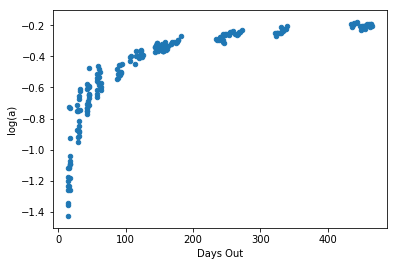

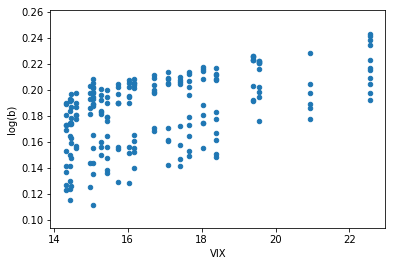

In [11]:
## ** END HERE ** ##

days_out_input = {15, 30, 45, 60, 90, 120, 150, 180, 240, 300, 450}
r_value = 0.9

data_table = get_data_table(days_out_input)
data_table = data_table[data_table['log(r^2)'] >= r_value]
data_table['VIX * Days Out'] = data_table['VIX'] * data_table['Days Out']
data_table['VIX ^ 2 * Days Out'] = (data_table['VIX'] ** 2) * data_table['Days Out']

## seemingly the best indicators
data_table.plot.scatter(x = 'Days Out', y = 'log(a)')
data_table.plot.scatter(x = 'VIX', y = 'log(b)')
# data_table.plot.scatter(x = 'VIX * Days Out', y = 'log(b)')
# data_table.plot.scatter(x = 'VIX ^ 2 * Days Out', y = 'log(b)')

a_fit = get_log_fit(data_table['Days Out'], data_table['log(a)'])
b_fit = get_log_fit(data_table['VIX'], data_table['log(b)'])
fit = (a_fit, b_fit)
fit

((0.30476371951832276, -1.8747762805750459, 0.8888485983438225),
 (0.02543325355684454, -0.07568815194183245, 0.7312628487500537))

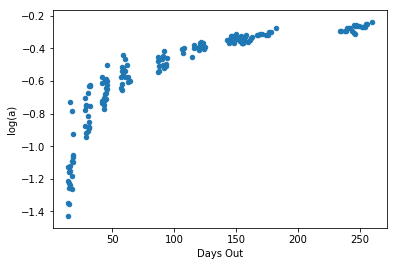

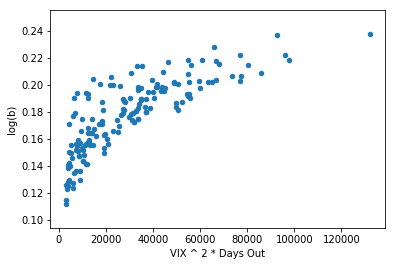

In [12]:
days_out_input = {15, 30, 45, 60, 90, 120, 150, 180, 240}
r_value = 0.9

data_table = get_data_table(days_out_input)
data_table = data_table[data_table['log(r^2)'] >= r_value]
data_table['VIX ^ 2 * Days Out'] = (data_table['VIX'] ** 2) * data_table['Days Out']

a_fit = get_log_fit(data_table['Days Out'], data_table['log(a)'])
b_fit = get_log_fit(data_table['VIX ^ 2 * Days Out'], data_table['log(b)'])
fit = (a_fit, b_fit)

data_table.plot.scatter(x = 'Days Out', y = 'log(a)')
data_table.plot.scatter(x = 'VIX ^ 2 * Days Out', y = 'log(b)')

fit

# data_table

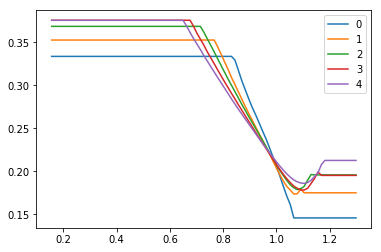

In [13]:
## visualization of implied vol curves across days out for given date

import matplotlib.pyplot as plt

date_input = '2015-10-01'
days_out_input = {30, 60, 90, 120, 150}

date_df = get_date_df(date_input)
days_out = get_days_out(date_input, days_out_input)
strikes = get_strikes(date_input, days_out)
moneyness = get_moneyness(date_input, days_out)

iv = []
for i in days_out:
    days_out_df = date_df.loc[date_df['Days Out'] == i]
    days_out_df = days_out_df[days_out_df['Moneyness'].isin(moneyness)]
    iv.append(list(days_out_df['Implied Vol']))    

iv_df = pd.DataFrame(index = moneyness)

i = 0
while i < len(days_out):
    iv_df[i] = iv[i]
    i += 1
    
iv_df

plt.figure()
iv_df.plot()

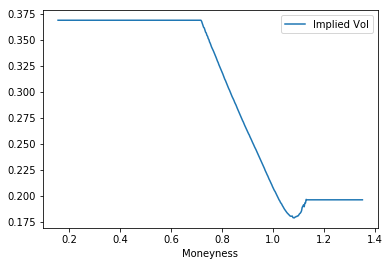

In [14]:
## visualization of implied vol curve for single expiration

date_input = '2015-10-01'
days_out_input = {90}

date_df = get_date_df(date_input)
days_out = get_days_out(date_input, days_out_input)
strikes = get_strikes(date_input, days_out)

days_out_df = date_df.loc[date_df['Days Out'] == days_out]
days_out_df = days_out_df[days_out_df['Strike'].isin(strikes)]

days_out_df = days_out_df[['Moneyness', 'Implied Vol']]
days_out_df = days_out_df.set_index('Moneyness')

plt.figure()
days_out_df.plot()

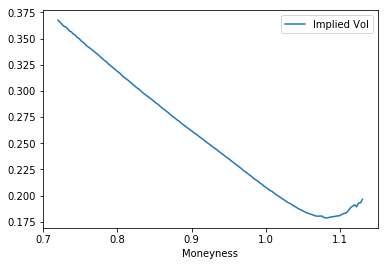

In [15]:
## refined visualization of implied vol curve for single expiration

date_input = '2015-10-01'
days_out_input = {90}

date_df = get_date_df(date_input)
days_out = get_days_out(date_input, days_out_input)
strikes = get_strikes(date_input, days_out)

days_out_df = date_df.loc[date_df['Days Out'] == days_out]
days_out_df = days_out_df[days_out_df['Strike'].isin(strikes)]

days_out_df = days_out_df[['Moneyness', 'Implied Vol']]
days_out_df = days_out_df.set_index('Moneyness')
days_out_df = days_out_df.drop_duplicates(subset=['Implied Vol'], keep=False)

plt.figure()
days_out_df.plot()